In [1]:
from fdfdpy import Simulation

import sys
sys.path.append("..")

from optimization import Optimization
from structures import two_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
# fundamental constants and simulation parameters
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                   # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 20              # amplitude of modal source (A/L0^2?)

In [17]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 6e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [18]:
# geometric parameters
L = 20         # length of design region (L0)
H = 5         # height of design region (L0)
w = 0.5        # width of waveguides (L0)
l = 4         # length of waveguide from PML to design region (L0)
spc = 2     # space between box and PML (L0)

Computed a domain with 310 grids in x and 120 grids in y
The simulation has 20 grids per free space wavelength


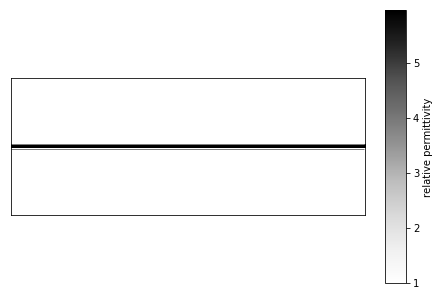

In [19]:
# define permittivity of two port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega, eps_r, dl, NPML, pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [20]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=source_amp)
simulation.setup_modes()
print('Calculate an input power of {} Watts/L0'.format(simulation.W_in))

# out modal profile
sim_out = Simulation(omega, eps_r, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)

# in modal profile
sim_in = Simulation(omega, eps_r, dl, NPML, 'Ez')
sim_in.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l*2/3/dl), ny], int(Ny/2))
sim_in.setup_modes()
J_in = np.abs(sim_in.src)

Calculate an input power of 7.886309172133723 Watts/L0


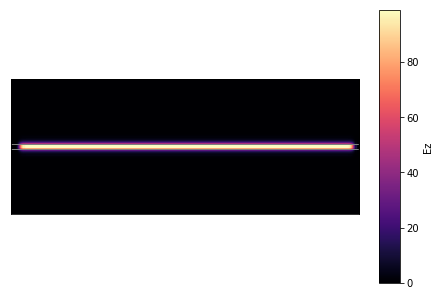

In [21]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [10]:
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
import copy
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

### First let's try to make a cavity

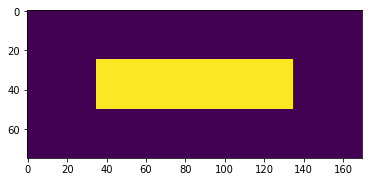

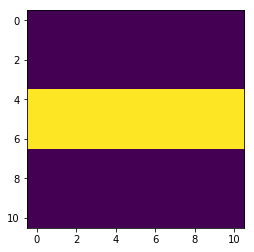

In [15]:
plt.imshow(design_region.T)
plt.show()
plt.imshow(eps_r[nx-5:nx+6, ny-5:ny+6].T)
plt.show()

In [ ]:
J = {}
J['linear']    = lambda e, eps_r:  np.square(np.abs(e[nx, ny]))
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e[nx, ny])
des_cavity = 

In [9]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*J_out) / np.sum(np.square(np.abs(e))) 
J['nonlinear'] = lambda e, eps_r: -np.sum(np.square(np.abs(e))*J_out) / np.sum(np.square(np.abs(e))) 
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*J_out / np.sum(np.square(np.abs(e))*J_in) \
                                     - np.sum(np.square(np.abs(e))*J_out) / np.sum(np.square(np.abs(e))*J_in) * 1/e
dJ['dE_nonlinear'] = lambda e, eps_r:- np.conj(e)*J_out / np.sum(np.square(np.abs(e))*J_in) \
                                     - np.sum(np.square(np.abs(e))*J_out) / np.sum(np.square(np.abs(e))*J_in) * 1/e
dJ['total']     = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin


In [10]:
# define linear and nonlinear parts of objective function + the total objective function form
import autograd.numpy as np
from autograd import grad

J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*J_out)
J['nonlinear'] = lambda e, eps_r:  -np.sum(np.square(np.abs(e))*J_out)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJ = {}
dJ['dE_linear']    = grad(J['linear'], 0)
dJ['dE_nonlinear'] = grad(J['nonlinear'], 0)
# dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_out
# dJ['dE_nonlinear'] = lambda e, eps_r: -np.conj(e)*J_out
dJ['total']        = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin


In [21]:
# optimization parameters
Nsteps =  2000
step_size = 4e-3
solver = 'newton'
opt_method = 'adam'

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_r
optimization = Optimization(Nsteps=Nsteps, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method, max_ind_shift=max_ind_shift)

# check the derivatives
(grad_avm, grad_num) = optimization.check_deriv_lin(simulation, design_region)
(grad_avm, grad_num) = optimization.check_deriv_nonlin(simulation, design_region)
print('differences: = \n{}'.format([abs(a - 2*n) for a, n in zip(grad_avm, grad_num)]))


differences: = 
[1.1239491496506355e-10, 3.883839637506227e-11, 6.437269890649152e-11, 3.868734725143167e-10, 2.457020593865731e-09]


In [22]:
# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, design_region)

100% (2000 of 2000) |####################| Elapsed Time: 0:31:48 ETA:  00:00:00

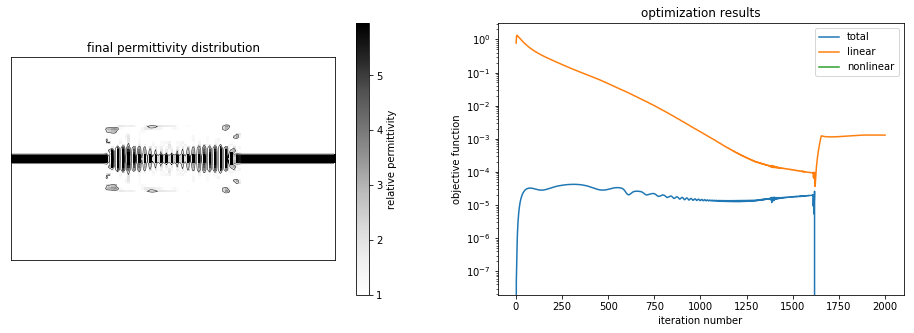

In [23]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

# ax1.plot(optimization.W_in)
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2, scaled='11W_in')
ax2.set_yscale('log')
plt.show()

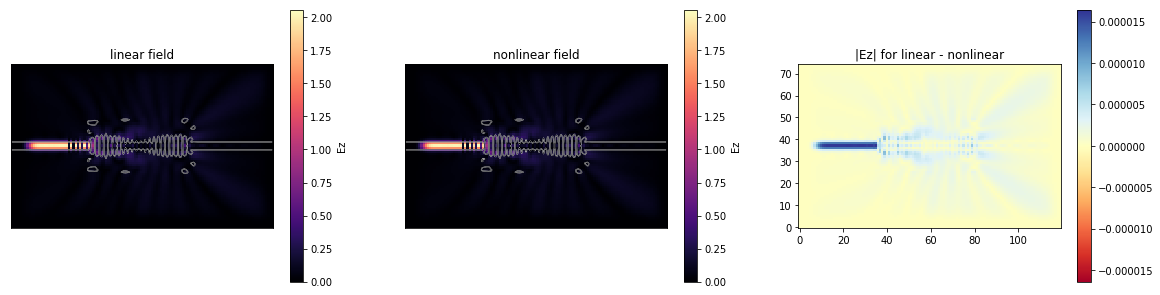

In [24]:
# compare the linear and nonlinear fields

# simulation.eps_r = new_eps

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=None)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=None)
ax2.set_title('nonlinear field')

# difference
difference = np.abs(Ez.T - Ez_nl.T)
im = plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu', origin='lower')
f.colorbar(im, ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.005442392370504851


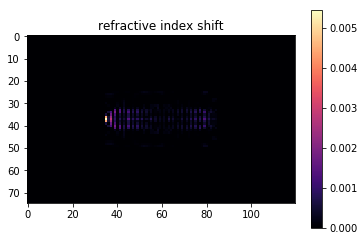

In [25]:
# compute the refractive index shift
index_shift = optimization.compute_index_shift(simulation)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

100% (10 of 10) |########################| Elapsed Time: 0:00:02 ETA:  00:00:00

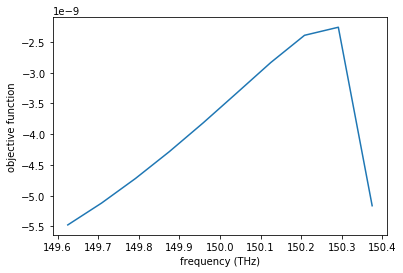

computed FWHM of 0.0 (THz):


In [26]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=10, df=1/200)
optimization.simulation.omega = omega
plt.plot([f/1e12 for f in freqs], objs)
plt.xlabel('frequency (THz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (THz):'.format(FWHM/1e12))


In [27]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))


difference of 5.740840835722351e-05 %
linear transmission    = -11.567682841544672
nonlinear transmission = -11.567400926129249
difference of 0.02819154154227732 %
